# **Análisis de Series de tiempo**
## Usando Gradient Boosting

# 1.Objetivo

La idea es poder leer el archivo que contiene la historia de Imacec chileno a partir de 2018 para el indicador general. Existen diferentes maneras de leer la información pero no es parte del objetivo presente código.

El espíritu es poder entregar un código simple para realizar un forecast para este indicador u otro, a través de Gradiant Boosting.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
data = [
    96.6, 92.8, 105.2, 102.0, 101.7, 98.5, 93.8, 98.2,
    94.3, 102.2, 105.6, 109.0, 98.6, 93.3, 106.5, 103.5, 103.2,
    99.1, 96.4, 101.6, 97.3, 97.7, 100.4, 110.0, 99.7, 95.9,
    102.1, 88.1, 86.9, 85.2, 85.0, 90.2, 92.1, 96.3, 101.3,
    110.6, 96.2, 94.0, 109.0, 101.5, 103.8, 102.6, 99.7, 106.4,
    104.5, 109.0, 114.9, 120.2, 103.3, 98.9, 115.2, 107.2,
    109.1, 105.4, 99.8, 107.7, 105.3, 107.2, 111.3, 118.3, 104.6,
    98.7, 113.3, 106.9, 108.8, 105.6, 103.0, 108.1, 106.1,
    109.1, 113.1, 118.3, 107.9, 104.2, 115.0, 111.2, 109.2,
    104.9, 107.1, 110.2, 106.3, 112.0, 115.8, 126.3
    ]

# Fechas correspondientes
dates = pd.date_range(start='2018-01-01', periods=len(data), freq='M')
df = pd.DataFrame({'fecha': dates, 'valor': data})

df['fecha'] = pd.DatetimeIndex(df['fecha'])
df.dtypes

<ipython-input-2-a849db794ede>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2018-01-01', periods=len(data), freq='M')


,0
fecha,datetime64[ns]
valor,float64


# 2.Presentación serie

La serie muestra historia desde enero de 2018, y se refleja todo el periodo de pandemia, en el cual el indicador sufrió una caída que no se explica por efectos de la misma serie.

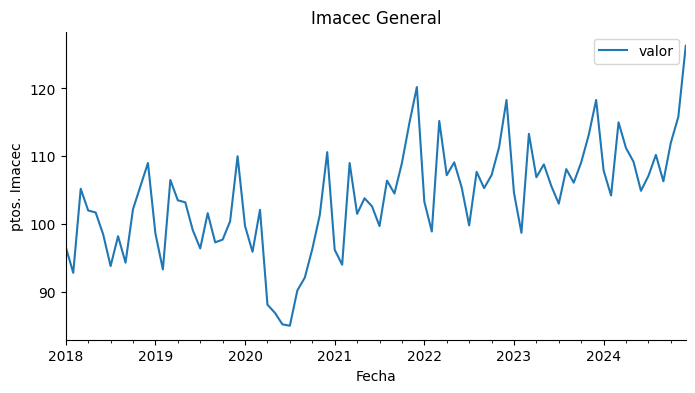

In [3]:
df.set_index('fecha').plot(figsize=(8, 4), title='Imacec General')
plt.xlabel('Fecha');plt.ylabel('ptos. Imacec')
plt.gca().spines[['top', 'right']].set_visible(False)

# 3.Entrenamiento

Para la fase de entrenamiento es necesario entregar una serie estacionaria o semi estacionaria. Para ello, es necesario al menos tomar diferenciaciones a un rezago.

In [4]:
def create_lag_features(df, n_lags=12):
    df_lagged = df.copy()
    for lag in range(1, n_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged['valor'].shift(lag)
    return df_lagged.dropna()

df_features = create_lag_features(df)

In [5]:
X = df_features.drop(columns=['fecha', 'valor'])
y = df_features['valor']

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#4.Forecast y error

Una vez entrenado el modelo, la serie de tiempo, está en condiciones de entregar una proyección. Para poder medir la calidad de la proyección, la serie entregada fue hasta diciembre, dejando "oculto" los 3 últimos meses observados para calcular un error emulando condiciones reales.

##4.1 Valores reales

Los valores reales observados fueron: 111.0, 104.2, 119.3 para el primer trimestre de 2025. Dichos indicadores serán de utilidad para el calculo de errores.

In [6]:
df_real = [111, 104.2, 119.3]
date_real = pd.date_range(start='2025-01-01', periods=len(df_real), freq='M')
df_real = pd.DataFrame({'fecha': date_real, 'valor_real': df_real})
df_real['fecha'] = pd.DatetimeIndex(df_real['fecha'])

<ipython-input-6-52c224fdc3af>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_real = pd.date_range(start='2025-01-01', periods=len(df_real), freq='M')


##4.2 Forecast

In [7]:
last_known = df['valor'].iloc[-12:].values
forecast = []
for _ in range(3):
    input_features = last_known[-12:].reshape(1, -1)
    pred = model.predict(input_features)[0]
    forecast.append(pred)
    last_known = np.append(last_known, pred)


In [8]:
future_dates = pd.date_range(start=df['fecha'].iloc[-1] + pd.offsets.MonthBegin(), periods=3, freq='MS')
forecast_series = pd.Series(forecast, index=future_dates)

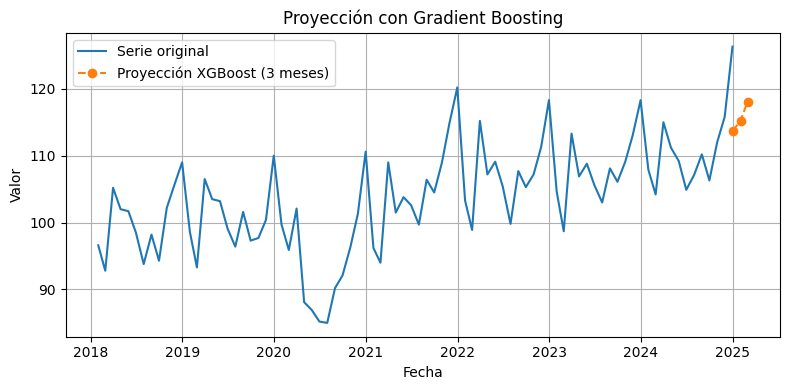

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(df['fecha'], df['valor'], label='Serie original')
plt.plot(forecast_series.index, forecast_series.values, label='Proyección XGBoost (3 meses)', linestyle='--', marker='o')
plt.title('Proyección con Gradient Boosting')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
date_fcts = pd.date_range(start='2025-01-01', periods=len(forecast_series.tolist()), freq='M')
df_fcts = pd.DataFrame({'fecha': date_fcts, 'valor_fcts': forecast_series.tolist()})
df_fcts['fecha'] = pd.DatetimeIndex(df_fcts['fecha'])

<ipython-input-10-4a2348e4cfd8>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_fcts = pd.date_range(start='2025-01-01', periods=len(forecast_series.tolist()), freq='M')


##4.3 MAPE

El error puede ser calculado de diferentes maneras, siendo el MAPE calculado como:
$MAPE_{n}=\frac{1}{n}\sum_{i=1}^{n}|(y_{obs,i}-y_{fcst,i})/y_{obs,i}|$.

Por tanto, el error es:

In [11]:
df_mape = df_real.merge(df_fcts, how='inner', on='fecha')
df_mape

,fecha,valor_real,valor_fcts
0,2025-01-31,111.0,113.721527
1,2025-02-28,104.2,115.203156
2,2025-03-31,119.3,118.063950


In [12]:
absolute_percentage_error = abs((df_mape['valor_fcts'] - df_mape['valor_real']) / df_mape['valor_real'])
mape = absolute_percentage_error.mean()

print(f"El MAPE es: {round(mape*100,2)}%")

El MAPE es: 4.68%
